In [24]:
# Importamos las bilbiotecas necesarias
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import scipy as sc
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

RETO

Predecir el número de viajes en bicicleta a través del puente Fermont en Seattle


In [10]:
# Cargamos los dos datasets
counts = pd.read_csv('Fremont_Bridge_Bicycle_Counter.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)


In [11]:
# Calculamos el trafico diario de bicicletas
daily = counts.resample('d').sum()
daily.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03,7042.0,3520.0,3522.0
2012-10-04,6950.0,3416.0,3534.0
2012-10-05,6296.0,3116.0,3180.0
2012-10-06,4012.0,2160.0,1852.0
2012-10-07,4284.0,2382.0,1902.0


In [12]:
daily['Total'] = daily.sum(axis=1)
daily.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk,Total
Date,,,,
2012-10-03,7042.0,3520.0,3522.0,14084.0
2012-10-04,6950.0,3416.0,3534.0,13900.0
2012-10-05,6296.0,3116.0,3180.0,12592.0
2012-10-06,4012.0,2160.0,1852.0,8024.0
2012-10-07,4284.0,2382.0,1902.0,8568.0


In [13]:
daily = daily[['Total']]
daily.head()

,Total
Date,
2012-10-03,14084.0
2012-10-04,13900.0
2012-10-05,12592.0
2012-10-06,8024.0
2012-10-07,8568.0


In [14]:
# Hint: Algunos días como los fines de semana incentivan el uso de bicicleta
# Solución: Creamos las primeras 7 variables las cuales serán un ID del día de la semana
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

# Hint: Los días libres son buenos para andar en bicicleta
# Solución: Crearemos también una variable para identificar los días festivos
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

# Hint: Seattle es una ciudad donde el número de horas de luz en el día varían mucho durante el año
# Solución: Crearemos una variable que nos indique el número de horas de luz en el día
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily



C:\Users\tavok\AppData\Local\Temp\ipykernel_4156\1083517346.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs
Date,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208
...,...,...,...,...,...,...,...,...,...,...
2022-04-26,4674.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.967394
2022-04-27,5766.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.020464
2022-04-28,5032.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.073143


(8.0, 17.0)

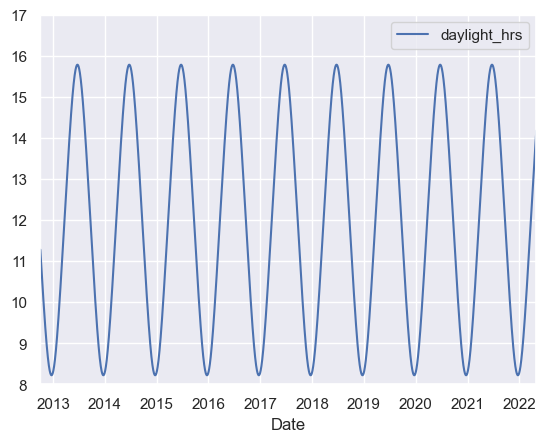

In [15]:
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [16]:
# Hint: El clima es importante cuando queremos salir a montar bicicleta
# Solución: Calculamos un promedio de temperatura por día 
# Agregamos una variable de probabilidad de lluvia
# Agregamos una variable para los días sin lluvia (es importante saber si habrá poca lluvia pero más importante saber si no habrá)

# Las temperaturas estan en 1/10 grados C; Convertimos los datos a grados C
weather['TMIN'] /= 10
#weather.head()

weather['TMAX'] /= 10
#weather.head()

weather['Temp (C)'] =0.5 * (weather['TMIN'] + weather['TMAX'])
#weather.head()

# La precipitación esta en 1/10 mm; Convertimos a pulgadas
weather['PRCP'] /= 254
weather.head()

,STATION,NAME,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,...,WT05,WT08,WT09,WT13,WT14,WT16,WT17,WT18,WT22,Temp (C)
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",10.51,NaN,NaN,0.000000,0.0,0.0,NaN,5.5,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,4.80
2012-01-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",10.07,NaN,NaN,0.001693,0.0,0.0,NaN,5.1,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,4.40
2012-01-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",5.14,NaN,NaN,0.000118,0.0,0.0,NaN,5.3,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.90
2012-01-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",10.51,NaN,NaN,0.003150,0.0,0.0,NaN,5.4,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,4.80
2012-01-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",13.65,NaN,NaN,0.000197,0.0,0.0,NaN,4.8,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.25


In [17]:
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1.0
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1.0
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1.0
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1.0
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1.0


In [18]:
# Hint: El calentamiento global modifica las temperaturas cada año
# Sol: Creamos una variable "contador" que nos ayuda a dar al modelo intuición sobre el año en curso
daily['annual'] = (daily.index - daily.index[0]).days / 365.

# Veamos el resultado
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1.0,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1.0,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1.0,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1.0,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1.0,0.010959


In [19]:
daily.dropna(subset=["Temp (C)"],inplace=True)
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000,5.60,1.0,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000000,5.65,1.0,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000000,5.95,1.0,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000000,6.05,1.0,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000000,6.05,1.0,0.010959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,4420.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.243449,0.000197,4.20,0.0,4.235616
2016-12-28,5888.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.252283,0.000000,4.25,1.0,4.238356
2016-12-29,4536.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.262456,0.000197,4.40,0.0,4.241096


In [20]:
daily.rename(columns = {'Temp (C)':'Temperatura'}, inplace = True)
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temperatura,dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000,5.60,1.0,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000000,5.65,1.0,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000000,5.95,1.0,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000000,6.05,1.0,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000000,6.05,1.0,0.010959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,4420.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.243449,0.000197,4.20,0.0,4.235616
2016-12-28,5888.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.252283,0.000000,4.25,1.0,4.238356
2016-12-29,4536.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.262456,0.000197,4.40,0.0,4.241096


Ahora si viene el reto:

Agrega una columna en el dataframe daily que se llame predicted y coloca en dicha columna los valores de una predicción de trafico de bicicletas.

Hint 1: Las variables las creamos nosotros mismos y las conocemos a detalle. Podemos concluir que el único problema adicional es que tenemos algunos vacíos así que será el único tratamiento adicional que necesitamos y como tenemos datos suficientes los vamos a borrar. Para este reto tampoco haremos reducción de la dimensionalidad ni detección de outliers ya que sabemos (por construcción) que todas las variables son independientes y aportan de manera significativa. Además se encuentran en una escala correcta y sin outliers.

Hint 2: Crea un modelo de regresión lineal

Hint 3: sklearn tiene una clase para crear el modelo

from sklearn.linear_model import LinearRegression La solución de esta sección se encuentra en el siguiente link

el password lo compartiremos en la sesión de mentoría

In [21]:
X = daily.iloc[: , 1:]
X

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temperatura,dry day,annual
Date,,,,,,,,,,,,,
2012-10-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000,5.60,1.0,0.000000
2012-10-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000000,5.65,1.0,0.002740
2012-10-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000000,5.95,1.0,0.005479
2012-10-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000000,6.05,1.0,0.008219
2012-10-07,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000000,6.05,1.0,0.010959
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.243449,0.000197,4.20,0.0,4.235616
2016-12-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.252283,0.000000,4.25,1.0,4.238356
2016-12-29,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.262456,0.000197,4.40,0.0,4.241096


In [22]:
Y = daily.Total
Y

Date
2012-10-03    14084.0
2012-10-04    13900.0
2012-10-05    12592.0
2012-10-06     8024.0
2012-10-07     8568.0
               ...   
2016-12-27     4420.0
2016-12-28     5888.0
2016-12-29     4536.0
2016-12-30     4364.0
2016-12-31     1888.0
Freq: D, Name: Total, Length: 1551, dtype: float64

In [25]:
model = linear_model.LinearRegression().fit(X, Y)
print("Coeficientes sklearn:", model.intercept_, model.coef_)

print("Error RLM:", mean_squared_error(Y, model.predict(X)))
#print("Error RLS:", get_mse(yp, Y))

Coeficientes sklearn: -1887809398732445.0 [ 1.88780940e+15  1.88780940e+15  1.88780940e+15  1.88780940e+15
  1.88780940e+15  1.88780940e+15  1.88780940e+15 -4.58194547e+03
  4.64477849e+02 -6.77202198e+05  1.56280528e+03  2.05679030e+03
  9.54949341e+01]
Error RLM: 3564955.276273372


In [26]:
predictions = model.predict(X)
predictions

array([14098.  , 13545.  , 12641.5 , ...,  8432.75,  6469.5 ,   275.25])

In [27]:
daily['Predicciones'] = predictions
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temperatura,dry day,annual,Predicciones
Date,,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000,5.60,1.0,0.000000,14098.00
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000000,5.65,1.0,0.002740,13545.00
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000000,5.95,1.0,0.005479,12641.50
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000000,6.05,1.0,0.008219,7535.00
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000000,6.05,1.0,0.010959,7295.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,4420.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.243449,0.000197,4.20,0.0,4.235616,8748.75
2016-12-28,5888.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.252283,0.000000,4.25,1.0,4.238356,10988.00
2016-12-29,4536.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.262456,0.000197,4.40,0.0,4.241096,8432.75


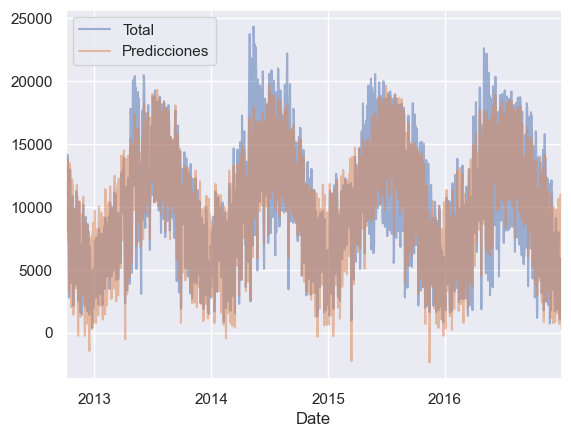

In [28]:
daily[['Total', 'Predicciones']].plot(alpha=0.5);

Pdemos determinar que nuestro modelo quedó de la siguiente manera:

Y = 1.88780940e+15(Mon) + 1.88780940e+15(Tue) + 1.88780940e+15(Wed) + 1.88780940e+15(Tue) + 1.88780940e+15(Fri) + 1.88780940e+15(Sat) + 1.88780940e+15(Sun) - 4.58194547e+03(holiday) + 4.64477849e+02(daylight_hrs) - 6.77202198e+05(PRCP) + 1.56280528e+03(Temperatura) + 2.05679030e+03(dry day) + 9.54949341e+01(anual)

Observamos que las variables de los días de la semana actúan como intercepto, por lo que omitimos ese predictor.

Vamos a concentrarnos en especial dos variables para poder interpretar el modelo, los cuales son Temperatura y horas del día.

Si mantenemos todas las demás variables constantes, Si la temperatura aumenta en una unidad, esperamos al final del día una aumento de 1,562 bicicletas en preomedio al día.

Por otro lado, si mantenemos las demás variables constantes, Si se añade una hora más de luz al día, se espera un incremento de 464 bicicletas en promedia al día.
